<a href="https://colab.research.google.com/github/mariuszkx5/ML-Projects/blob/master/LogisticReggresionFromScrach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy (cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***. Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego różniczkowania funkcji (np. Tensorflow, pytorch, autograd). 

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz



# Downloading the Data

In [0]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2020-04-16 08:52:29--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 104.28.7.204, 2606:4700:3031::681c:6cc, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz.1’

train-images-idx3-u 100%[===================>]   9.45M  12.5MB/s    in 0.8s    

2020-04-16 08:52:30 (12.5 MB/s) - ‘train-images-idx3-ubyte.gz.1’ saved [9912422/9912422]

--2020-04-16 08:52:33--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 104.28.7.204, 2606:4700:3031::681c:6cc, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz.1’

train-labels-idx1-u 100%[=========

In [0]:
!pip install idx2numpy

In [0]:
import idx2numpy
import gzip
import numpy as np

Train set

In [0]:
image_size = 28

f = gzip.open('train-images-idx3-ubyte.gz','r')

trainImages = idx2numpy.convert_from_file(f)
trainImages.reshape(-1, image_size, image_size, 1)

f = gzip.open('train-labels-idx1-ubyte.gz','r')

trainLabels = idx2numpy.convert_from_file(f)

Test set

In [0]:
f = gzip.open('t10k-images-idx3-ubyte.gz','r')

testImages = idx2numpy.convert_from_file(f)
testImages.reshape(-1, image_size, image_size, 1)

f = gzip.open('t10k-labels-idx1-ubyte.gz','r')

testLabels = idx2numpy.convert_from_file(f)

# Preparing the Data

Converting numbers to the Prime, Composite labels and removing 0 and 1 from dataset

In [0]:
def numb2bin(Images, Labels):
  binLabels = []
  Data = []
  numbOfPrimes = 0
  numbOfComposite = 0
  
  for i, item in enumerate(Labels):
    if item in [2, 3, 5, 7]:
      binLabels.append(1)
      Data.append(Images[i])
      numbOfPrimes += 1
    elif item in [4, 6, 8, 9]:
      binLabels.append(0)
      Data.append(Images[i])
      numbOfComposite += 1
  
  Data = np.array(Data).reshape(-1, 28*28)
  binLabels = np.array(binLabels)
  
  return Data, binLabels, numbOfPrimes ,numbOfComposite

In [0]:
trainImages, trainBinaryLabels, numbOfPrimes, numbOfComposite = numb2bin(trainImages, trainLabels)
testImages, testBinaryLabels, *_ = numb2bin(testImages, testLabels)

<BarContainer object of 2 artists>

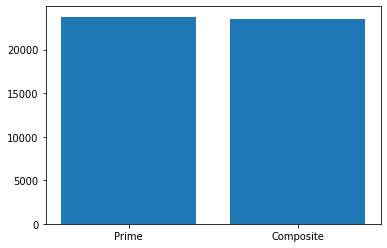

In [0]:
import matplotlib.pyplot as plt

plt.bar(['Prime', 'Composite'], [numbOfPrimes, numbOfComposite])

The training data are balanced

# Creating the model

Cost function --> cross entropy

In [0]:
class Model():
  def __init__(self, lr = 0.01, momentum = 0.2, n_iters = 5):
    self.lr = lr
    self.n_iters = n_iters
    self.momentum = momentum
    self.decay_rate = None
    self.weights = None
    self.bias = None
    self.steps = 0


  def fit(self, X, y):
    #init parameters
    n_samples, n_features = X.shape
    self.weights = np.zeros(n_features)
    self.bias = 0
    
    dw_old = np.zeros(n_features)
    db_old = 0

    # Stochastic Gradient Decent with momentum
    for _ in range(self.n_iters):
      for i in range(n_samples):
        rand_index = np.random.randint(0,n_samples)

        Xi = X[rand_index,:]
        yi = y[rand_index]

        linear_model = np.dot(Xi, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)

        # Learning rate Time-base declay --> lr = lr0/(1+kt)
        self.decay_rate = self.lr/(n_samples*self.n_iters)
        self.lr *= (1. / (1. + self.decay_rate * self.steps))
        self.momentum *= (1. / (1. + self.decay_rate * self.steps))
        
        dw = (1/n_samples)*np.dot(Xi.T, (y_predicted-yi)) + self.momentum * dw_old
        db = (1/n_samples)*np.sum(y_predicted-yi) + self.momentum * db_old
        
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

        dw_old = dw
        db_old = db

        self.steps += 1


  def predict(self, X):
    linear_model = np.dot(X, self.weights) + self.bias
    y_predicted = self._sigmoid(linear_model)
    y_predicted_cls = [1 if i> 0.5 else 0 for i in y_predicted]
    return np.array(y_predicted_cls)
  

  def _sigmoid(self, X):
    return 1/(1 + np.exp(-X))


  @staticmethod
  def evaluate(y_true, y_pred):
    accuracy = (np.sum(y_true == y_pred))/len(y_true)
    return accuracy
    

  def get_params(self):
    return {'lr': self.lr, 'n_iters' :self.n_iters, 'momentum': self.momentum}


# Choosing the optimal hyperparameters using Random Search and K-fold cross-validation

In [0]:
from sklearn.model_selection import KFold

def random_search_CV(X, y, n_trials = 1, cv = 3):
  best_accuracy = 0
  best_parameters = [None]*3
  kf = KFold(n_splits=cv, shuffle=True, random_state=None)

  for _ in range(n_trials):
    # Random hyperparamaters
    lr_exponent = 2*np.random.random_sample() + 1
    lr = 10**(-lr_exponent)
    momentum = 0.4*np.random.random_sample() + 0.4
    n_iters = np.random.randint(12, 35)

    # K-Fold Cross Validation
    folds = kf.split(X)    
    accuracy = [] 

    for fold in folds:   
      training_indexes, validating_indexes = fold      
      
      train_X = X[training_indexes]
      train_y = y[training_indexes]

      validation_X = X[validating_indexes]
      validation_y = y[validating_indexes]
      
      model = Model(n_iters=n_iters, lr=lr, momentum=momentum)
      model.fit(X=train_X, y=train_y)
      y_pred = model.predict(X=validation_X)

      accuracy.append(model.evaluate(validation_y, y_pred))
    
    avg_accuracy = sum(accuracy)/cv

    if best_accuracy < avg_accuracy:
      best_accuracy = avg_accuracy
      best_parameters = [lr, momentum, n_iters]
      print('Best accuracy so far: {}'.format(best_accuracy))
      print('Best parameters so far: lr = {}, momentum = {}, n_iter = {} '.format(lr, momentum, n_iters))

  return best_parameters


In [0]:
lr, momentum, n_iters = random_search_CV(X=trainImages, y=trainBinaryLabels, n_trials=50, cv=3)

Best accuracy so far: 0.9010034375040812
Best parameters so far: lr = 0.034792478664685, momentum = 0.7647116289388838, n_iter = 13 
Best accuracy so far: 0.9084821304305009
Best parameters so far: lr = 0.003832057207562159, momentum = 0.6311155024128364, n_iter = 17 
Best accuracy so far: 0.9087778527122982
Best parameters so far: lr = 0.017272980561748398, momentum = 0.731229810113643, n_iter = 25 
Best accuracy so far: 0.9091581036073827
Best parameters so far: lr = 0.00902117931076619, momentum = 0.7039020768834343, n_iter = 28 
Best accuracy so far: 0.9096018543922609
Best parameters so far: lr = 0.0104379795267122, momentum = 0.6794452681295233, n_iter = 13 
Best accuracy so far: 0.9096440417123007
Best parameters so far: lr = 0.020020737698944514, momentum = 0.5562869361032033, n_iter = 15 
Best accuracy so far: 0.9102988911039698
Best parameters so far: lr = 0.010915607088151646, momentum = 0.7181983799889546, n_iter = 29 


[0.010915607088151646, 0.7181983799889546, 29]

# Training the model and testing it on the unseen data

In [0]:
lr_clf = Model(n_iters = n_iters, lr = lr, momentum=momentum)

In [0]:
lr_clf.fit(X=trainImages, y=trainBinaryLabels)

In [0]:
y_pred = lr_clf.predict(X=testImages)

In [0]:
lr_clf.evaluate(testBinaryLabels, y_pred)

0.9188332276474318

# Visualization of the model's operation

In [0]:
def numb2labels(y):
  return ['Prime' if i> 0.5 else 'Composite' for i in y]

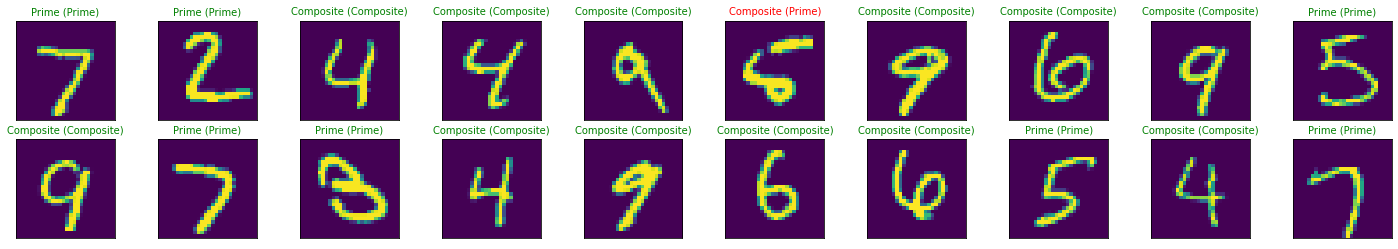

In [0]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(testImages[idx].reshape(image_size, image_size))
  ax.set_title("{} ({})".format(numb2labels(y_pred)[idx], numb2labels(testBinaryLabels)[idx]), color=("green" if y_pred[idx]==testBinaryLabels[idx] else "red"), fontsize = 10)

# Summary


* The logistic regression model has been implemented and trained by the SGD algorithm with momentum in accordance with the requirements of the task. 
Cross entropy function has been used as the cost function in the model training process. It has been decided to reduce the learning rate value along with the steps of the training algorithm to boost the performance of the model. It has been decided that the decay rate would be fixed and determined based on the equation decay_rate = lr/(n_samples*n_iters) to reduce the number of hyperparameters.

* The Random Search and K-Fold cross-validation methods have been used to determine optimal Hyperparameters. These are time-consuming methods, but the small complexity of the built model has allowed their use. The best model accuracy equal **91.88%** for unseen data and has been determined for lr = 0.01092, momentum = 0.7182, n_iter = 29.

* It is worth noting that the testing score (**91.88%**) is bigger than the validation score (**91.03%**). Maybe the testing dataset is less noisy. Probably the differences between prime and composite numbers in the test data are clearer.

* In my opinion, the biggest weak point of the classification performance is the algorithm used. The linear regression is a very simple model, too simple to get better accuracy.

* I think that using models such as CNN which take into account the context of a given pixel in a photo can allow for much better classification.

# References

*  "Deel Learning",  Goodfellow Ian , Bengio Yoshua , Courville Aaron http://www.deeplearningbook.org/
* https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
* https://scikit-learn.org/stable/modules/sgd.html
* https://towardsdatascience.com/random-search-vs-grid-search-for-hyperparameter-optimization-345e1422899d
